In [1]:
# import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
from matplotlib import mlab
from astropy.io import fits
from astropy.coordinates import SkyCoord
from dustmaps.planck import PlanckGNILCQuery
from pathlib import Path
from astropy.table import Table
import pandas as pd


In [2]:
outpath = './output/'
Path(outpath).mkdir(exist_ok=True)

In [3]:
def _check_range(rng, allowed):
    if rng is None:
        rng = allowed
    else:
        if not hasattr(rng, '__len__'):
            raise ValueError("range object does not have len() method")

        if rng[0] < allowed[0] or rng[1] > allowed[1]:
            raise ValueError("lon_range should be within [%s,%s]" % allowed)
    return rng


def randsphere(num, ra_range=None, dec_range=None, system='eq'):
    """
    Generate random points on the sphere
    You can limit the range in ra and dec.  To generate on a spherical cap, see
    randcap()
    parameters
    ----------
    num: integer
        The number of randoms to generate
    ra_range: list, optional
        Should be within range [0,360].  Default [0,360]
    dec_range: list, optional
        Should be within range [-90,90].  Default [-90,90]
    system: string
        Default is 'eq' for the ra-dec system.  Can also be 'xyz'.
    output
    ------
        for system == 'eq' the return is a tuple
            ra,dec = randsphere(...)
        for system == 'xyz' the return is a tuple
            x,y,z = randsphere(...)
    examples
    --------
        ra,dec = randsphere(2000, ra_range=[10,35], dec_range=[-25,15])
        x,y,z = randsphere(2000, system='xyz')
    """

    ra_range = _check_range(ra_range, [0.0, 360.0])
    dec_range = _check_range(dec_range, [-90.0, 90.0])

    ra = np.random.random(num)  # 0-1之间的随机数array
    ra *= (ra_range[1] - ra_range[0])
    if ra_range[0] > 0:
        ra += ra_range[0]

    # number [-1,1)
    cosdec_min = np.cos(np.deg2rad(90.0 + dec_range[0]))
    cosdec_max = np.cos(np.deg2rad(90.0 + dec_range[1]))
    v = np.random.random(num)
    v *= (cosdec_max - cosdec_min)
    v += cosdec_min

    np.clip(v, -1.0, 1.0, v)
    # Now this generates on [0,pi)
    dec = np.arccos(v)
    # convert to degrees
    # rad2deg(dec,dec)
    dec = np.rad2deg(dec)
    # now in range [-90,90.0)
    dec -= 90.0

    c1 = SkyCoord(ra=ra * u.degree, dec=dec * u.degree, frame='icrs')
    c2 = SkyCoord(l=ra * u.degree, b=dec * u.degree, frame='galactic')
    # if system == 'xyz':
    #     # x,y,z = eq2xyz(ra, dec)
    #     # return x,y,z
    #     return ra, dec
    # else:
    #     return ra, dec
#    return ra, dec
    if system == 'gal':
        return c2
    else:
        return c1

In [4]:
df0_good = pd.read_csv('/cargo/public/catdata/gpq_nir/goodqso.csv')
df0_good.ip.max()

21.6263008117676

In [5]:
mockGPQ_sum = len(df0_good)
mockGPQ_sum

175175

In [6]:
planck = PlanckGNILCQuery()


ectb = pd.read_csv('extcoefUKIDSS.csv', index_col=0)
ec = ectb['rb']  # 消光系数
bands = ['gp', 'rp', 'ip', 'zp', 'yp',
         'yap', 'jap', 'hap','kap','yab','jab','hab','kab',
         'w1vega', 'w2vega', 'w1ab','w2ab']

In [7]:
df0_good.columns

Index(['Unnamed: 0', 'source_id', 'ra', 'dec', 'redshift_qsoc', 'snrW1pm',
       'snrW2pm', 'w1vega', 'w2vega', 'gp', 'rp', 'ip', 'zp', 'yp',
       'g_mean_psf_mag_error', 'r_mean_psf_mag_error', 'i_mean_psf_mag_error',
       'z_mean_psf_mag_error', 'y_mean_psf_mag_error', 'yap', 'jap', 'hap',
       'kap', 'yAperMag3Err', 'j_1AperMag3Err', 'hAperMag3Err', 'kAperMag3Err',
       'pmRA_x', 'pmDE', 'e_pmRA', 'e_pmDE', 'l', 'b', 'w1ab', 'w2ab', 'yab',
       'jab', 'hab', 'kab', 'o_ra', 'o_dec', 'o_l', 'o_b', 'o_g', 'o_r', 'o_i',
       'o_z', 'o_y', 'o_yap', 'o_jap', 'o_hap', 'o_kap', 'o_jab', 'o_hab',
       'o_kab', 'o_w1vega', 'o_w2vega', 'o_w1ab', 'o_w2ab', 'o_ebv', 'Z_DR16Q',
       'EBV', 'e_gmag', 'e_rmag', 'e_imag', 'e_zmag', 'e_ymag', 'pmRA_s',
       'pmDE_s', 'e_pmRA_s', 'e_pmDE_s', 'dgp', 'drp', 'dip', 'dzp', 'dyp',
       'dyap', 'djap', 'dhap', 'dkap', 'dyab', 'djab', 'dhab', 'dkab',
       'dw1vega', 'dw2vega', 'dw1ab', 'dw2ab'],
      dtype='object')

# 做模拟（无放回）

In [8]:
class mocking:
    
    def __init__(self):
        self.selected = None
        self.unselected = None
        self.unselected_input = None
        self.selection_rate = 0
        self.selection_rate_average = 0
        self.selection_rate_list = []
        self.num_of_good = 0
        self.round = 0
        self.check = []
        self.input_list = []
        self.round_flag = 0
        
    def selectgood(self,not_selected=None, rounds=10):
        np.random.seed(self.round+1000)  # 每一轮模拟用不同的随机数种子
        self.round_flag=rounds
        
        if not_selected is not None:
            self.unselected = not_selected.copy()
            
        df_good = self.unselected.copy()

        # 设置随机位置(ra,dec,ebv)
        c = randsphere(len(df_good), [0.0, 360.0], [-5,5], system='gal')
        ceq = c.transform_to('icrs')
        ebv = planck(ceq)  
        
        df_good['ra'] = ceq.ra.deg
        df_good['dec'] = ceq.dec.deg
        df_good['l'] = c.l.deg
        df_good['b'] = c.b.deg
        df_good['ebv'] = ebv

        for b in bands:  # 加上指定位置处的消光后的星等:b
            db = 'd' + b
            if b[0] == 'g' or  b[0] == 'r' or b[0] == 'i' or b[0] == 'z' or b[0] == 'y' :
                df_good[b] = df_good[db] + df_good['ebv'] * ec[b[0]]  
            if b[0] == 'j' or  b[0] == 'h' or  b[0] == 'k':
                df_good[b] = df_good[db] + df_good['ebv'] * ec[b[0].upper()]                                        
            if b[0] == 'w':
                df_good[b] = df_good[db] + df_good['ebv'] * ec[b[0].upper()+b[1]]
        
        
        df2 = df_good.query("ip <= 23.1\
            and zp <= 22.3\
            and yp <= 21.3\
            and jap<= 19.8")
        
                
        self.unselected = df_good.drop(list(df2.index.values))
        self.input_list.append(self.unselected)
        
        self.selection_rate += len(df2)/mockGPQ_sum
        self.selection_rate_average += len(df2)/len(df_good)
        self.selection_rate_list.append(len(df2)/len(df_good))
        self.num_of_good += len(df2)
        self.round += 1
        
      
        if self.round < rounds:
            if self.round == 1:
                self.selected = df2
                print(self.selection_rate)                
            else:
                temp = self.selected
                self.selected = pd.concat([temp,df2],sort=False)
                # sort是用来sort column的排列顺序 不是用来sort index
                print(self.selection_rate)
                
            self.selectgood(rounds=self.round_flag)
            
        else:
            temp = self.selected
            self.selected = pd.concat([temp,df2],sort=False)
            self.selected.to_csv(outpath+'GoodMockGPQNIR_recycle_'+str()+'.csv', index=False)
            #self.selected.to_csv(outpath+'GoodMockGPQNIR_loopMocking_0.9.csv', index=False)
            print('MockGPQNIR number: {},\n'
                  'GoodMockGPQNIR number: {},\n'
                  'The average of selection rate is {},\n'
                  'Total selection rate:{},\n'
                  'Total rounds of mocking:{}.'.format(mockGPQ_sum, self.num_of_good,
                                                       self.selection_rate_average/self.round, 
                                                       self.selection_rate,self.round))
            
            return 0
                

In [9]:
# PlanckGNILCQuery
mockQSO =  mocking()
mockQSO.selectgood(not_selected=df0_good, rounds=10)

0.5096503496503496
0.7039075210503781
0.7933323819038104
0.8391265876980162
0.8663165406022548
0.8846068217496789
0.8970800627943485
0.9062309119451977
0.9135150563721992
MockGPQNIR number: 175175,
GoodMockGPQNIR number: 161021,
The average of selection rate is 0.20756737954379384,
Total selection rate:0.9192007992007992,
Total rounds of mocking:10.


In [9]:
# PlanckQuery
# mockQSO =  mocking()
# mockQSO.selectgood(not_selected=df0_good, rounds=10)

0.5493363779078064
0.758430141287284
0.8484658198943912
0.8910004281432852
0.9151819608962465
0.9288882546025402
0.9380448123305265
0.9447238475809904
0.9495190523761952
MockGPQNIR number: 175175,
GoodMockGPQNIR number: 166988,
The average of selection rate is 0.24476552812392036,
Total selection rate:0.9532638789781647,
Total rounds of mocking:10.


In [63]:
mockQSO.input_list[0]['o_i'].max()

21.4538993835449

In [73]:
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.serif'] = ['Times New Roman']
matplotlib.rcParams['xtick.direction'] = 'in'
matplotlib.rcParams['ytick.direction'] = 'in'

plt.rcParams["figure.figsize"] = (5,3) # 调整图片尺寸
plt.rcParams["figure.dpi"] = 120 # 提高图片分辨率

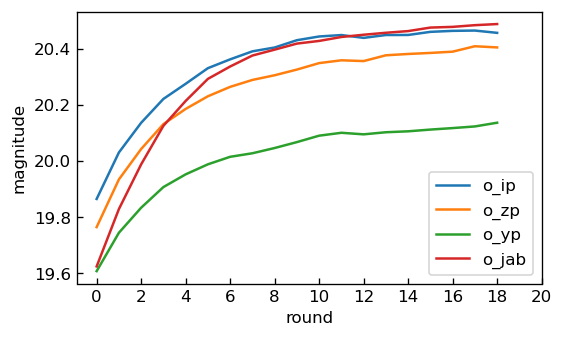

In [93]:
x = [i for i in range(19)]
y1 = [mockQSO.input_list[i]['o_i'].median() for i in range(19)]
y2 = [mockQSO.input_list[i]['o_z'].median() for i in range(19)]
y3 = [mockQSO.input_list[i]['o_y'].median() for i in range(19)]
y4 = [mockQSO.input_list[i]['o_jab'].median() for i in range(19)]
plt.plot(x,y1,label='o_ip')
plt.plot(x,y2,label='o_zp')
plt.plot(x,y3,label='o_yp')
plt.plot(x,y4,label='o_jab')
plt.xticks([0,2,4,6,8,10,12,14,16,18,20])
plt.xlabel('round')
plt.ylabel('magnitude')
plt.legend()

Text(0, 0.5, 'selection_rate of each round')

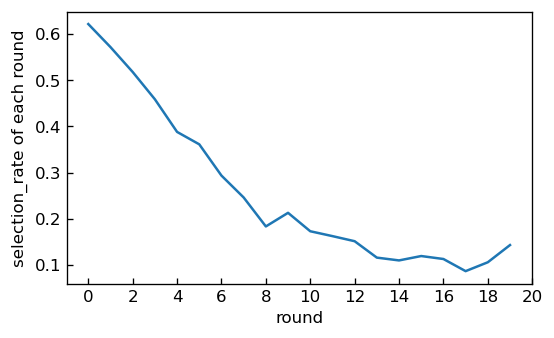

In [90]:
x = [i for i in range(20)]
y = mockQSO.selection_rate_list
plt.plot(x,y)
plt.xticks([0,2,4,6,8,10,12,14,16,18,20])
plt.xlabel('round')
plt.ylabel('selection_rate of each round')

In [11]:
# test of random seed
class loop:
    def __init__(self):
        self.round = 0
        self.list = []
    def test(self):
        np.random.seed(1002)
        a = np.random.random(6-self.round)
        self.list.append(a)
        self.round += 1
        if self.round < 4:
            self.test()
        else:
            print(self.list)
            return 0
loop = loop()
loop.test()

[array([0.12898829, 0.46115618, 0.41615393, 0.60272423, 0.18306805,
       0.41791271]), array([0.12898829, 0.46115618, 0.41615393, 0.60272423, 0.18306805]), array([0.12898829, 0.46115618, 0.41615393, 0.60272423]), array([0.12898829, 0.46115618, 0.41615393])]
